In [1]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
from rasterio.warp import transform
import xarray as xr
# Initialize the Earth Engine module.
ee.Initialize()

In [2]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################
# PATHS

# DOMAIN
# choose the modeling domain
domain = 'BEAU'

# path to directory where you want your output .tif and .asc files
dataPath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'
#########################################################################

In [3]:
# Download dem and veg data function
def get_lapse(domain, OUTpath):
    
    #path to domains
    domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
    domains = domains_resp.json()

    # These are the min and max corners of your domain in Lat, Long
    minLat = domains[domain]['Bbox']['latmin']
    #// Input the minimum long, lower left corner
    minLong = domains[domain]['Bbox']['lonmin']
    #// Input the max lat, upper right corner
    maxLat = domains[domain]['Bbox']['latmax']
    #// Input the max Long, upper right corner
    maxLong = domains[domain]['Bbox']['lonmax']

    # This resolution for the NLCD and DEM outputs for the SnowModel domain in meters
    sm_resolution = int(domains[domain]['cellsize'])

    # Define the final output projection using EPSG codes
    epsg_code = domains[domain]['mod_proj']

    my_domain = ee.Geometry.Rectangle(**{'coords':[minLong,minLat,maxLong,maxLat],'proj': 'EPSG:4326','geodesic':True,})
    
    # ////////////////   Datasets of Interest  //////////////////////
    # ////////                Climate DATA                    /////////
    # ///////////////////////////////////////////////////////////////

    # NOTE: these are 2.5 arc min. Roughly ~4 km. Seems to be the best option available...
    # NOTE: you can pick any 30 year period you want. This is for 1989-2019.

    #/////////  Import Temp/Prec Climatologies   ////////////////////
    # Use the TerraClimate dataset because GEE does not contain PRISM data for AK
    terraclim = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE');
    # Select precipitation by month
    ppt = terraclim.select('pr');
    janppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(1,1,'month')).mean()
    febppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(2,2,'month')).mean()
    marppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(3,3,'month')).mean()
    aprppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(4,4,'month')).mean()
    mayppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(5,5,'month')).mean()
    junppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(6,6,'month')).mean()
    julppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(7,7,'month')).mean()
    augppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(8,8,'month')).mean()
    sepppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(9,9,'month')).mean()
    octppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(10,10,'month')).mean()
    novppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(11,11,'month')).mean()
    decppt = ppt.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(12,12,'month')).mean()

    # Select temperature by month and take the mean
    tmin = terraclim.select('tmmn');
    jantemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(1,1,'month')).mean()
    febtemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(2,2,'month')).mean()
    martemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(3,3,'month')).mean()
    aprtemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(4,4,'month')).mean()
    maytemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(5,5,'month')).mean()
    juntemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(6,6,'month')).mean()
    jultemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(7,7,'month')).mean()
    augtemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(8,8,'month')).mean()
    septemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(9,9,'month')).mean()
    octtemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(10,10,'month')).mean()
    novtemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(11,11,'month')).mean()
    dectemp_min = tmin.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(12,12,'month')).mean()

    # Select max temperature by month
    tmax = terraclim.select('tmmx');
    jantemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(1,1,'month')).mean()
    febtemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(2,2,'month')).mean()
    martemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(3,3,'month')).mean()
    aprtemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(4,4,'month')).mean()
    maytemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(5,5,'month')).mean()
    juntemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(6,6,'month')).mean()
    jultemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(7,7,'month')).mean()
    augtemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(8,8,'month')).mean()
    septemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(9,9,'month')).mean()
    octtemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(10,10,'month')).mean()
    novtemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(11,11,'month')).mean()
    dectemp_max = tmax.filter(ee.Filter.calendarRange(1989,2019,'year')).filter(ee.Filter.calendarRange(12,12,'month')).mean()

    # Create two images with constant values for division later
    two = ee.Image.constant(2);
    scale = ee.Image.constant(0.1)

    # Add the max and min temp images, then divide by 2 for obtaining the mean (blunt approximation)
    # Also, scale the output to the correct units
    jantemp_add = jantemp_min.add(jantemp_max)
    jantemp = jantemp_add.divide(two).multiply(scale)
    febtemp_add = febtemp_min.add(febtemp_max)
    febtemp = febtemp_add.divide(two).multiply(scale)
    martemp_add = martemp_min.add(martemp_max)
    martemp = martemp_add.divide(two).multiply(scale)
    aprtemp_add = aprtemp_min.add(aprtemp_max)
    aprtemp = aprtemp_add.divide(two).multiply(scale)
    maytemp_add = maytemp_min.add(maytemp_max)
    maytemp = maytemp_add.divide(two).multiply(scale)
    juntemp_add = juntemp_min.add(juntemp_max)
    juntemp = juntemp_add.divide(two).multiply(scale)
    jultemp_add = jultemp_min.add(jultemp_max)
    jultemp = jultemp_add.divide(two).multiply(scale)
    augtemp_add = augtemp_min.add(augtemp_max)
    augtemp = augtemp_add.divide(two).multiply(scale)
    septemp_add = septemp_min.add(septemp_max)
    septemp = septemp_add.divide(two).multiply(scale)
    octtemp_add = octtemp_min.add(octtemp_max)
    octtemp = octtemp_add.divide(two).multiply(scale)
    novtemp_add = novtemp_min.add(novtemp_max)
    novtemp = novtemp_add.divide(two).multiply(scale)
    dectemp_add = dectemp_min.add(dectemp_max)
    dectemp = dectemp_add.divide(two).multiply(scale)


    # export monthly precip images to tifs
    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_1.tif')
    geemap.ee_export_image(janppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_2.tif')
    geemap.ee_export_image(febppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_3.tif')
    geemap.ee_export_image(marppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_4.tif')
    geemap.ee_export_image(aprppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_5.tif')
    geemap.ee_export_image(mayppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_6.tif')
    geemap.ee_export_image(junppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_7.tif')
    geemap.ee_export_image(julppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_8.tif')
    geemap.ee_export_image(augppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_9.tif')
    geemap.ee_export_image(sepppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_10.tif')
    geemap.ee_export_image(octppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_11.tif')
    geemap.ee_export_image(novppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_ppt_12.tif')
    geemap.ee_export_image(decppt, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    # Export monthly temp images to tif
    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_1.tif')
    geemap.ee_export_image(jantemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_2.tif')
    geemap.ee_export_image(febtemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_3.tif')
    geemap.ee_export_image(martemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_4.tif')
    geemap.ee_export_image(aprtemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_5.tif')
    geemap.ee_export_image(maytemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_6.tif')
    geemap.ee_export_image(juntemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_7.tif')
    geemap.ee_export_image(jultemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_8.tif')
    geemap.ee_export_image(augtemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_9.tif')
    geemap.ee_export_image(septemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_10.tif')
    geemap.ee_export_image(octtemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_11.tif')
    geemap.ee_export_image(novtemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)

    filename = os.path.join(OUTpath, 'clim/',domain+'_tmp_12.tif')
    geemap.ee_export_image(dectemp, filename=filename, scale=sm_resolution, region=my_domain, crs = epsg_code)



In [4]:
# download monthly temp and precip lapse rates from GEE
get_lapse(domain, dataPath)

Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/clim/BEAU_ppt_1.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/clim/BEAU_ppt_2.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/clim/BEAU_ppt_3.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/clim/BEAU_ppt_4.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/clim/BEAU_ppt_5.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/clim/BEAU_ppt_6.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/clim/BEAU_ppt_7.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BEAU/clim/BEAU_ppt_8.tif
Generating URL ...
Please wait ...
Data downloaded to /n

In [4]:
def compute_lapse(dataPath, domain):
    #months
    months = np.arange(1,13).tolist()

    # get dem data
    INfile = dataPath+domain+'_dem.tif'
    dem = xr.open_rasterio(INfile)

    # compute monthly temp lapse rates 
    tlapse = []
    print('Computing temp lapse rates')
    for mo in range(12):
        month = str(mo+1)
        INfile = dataPath+'clim/'+domain+'_tmp_'+month+'.tif'
        da = xr.open_rasterio(INfile)
        # mask out ocean in dem
        # div by 1000 to make deg / km
        demmask = dem.where(dem>0).values/1000
        # mask out ocean in climatology data
        damask = da.where(dem>0).values
        # compute polynomial coefficient 
        p = np.polyfit(demmask[~np.isnan(demmask)], damask[~np.isnan(damask)], 1)
        #use neg to make a pos number. See micromet.f for explanation
        tlapse.append(-p[0])
        print(month,-p[0])

    # compute monthly precip lapse rates 
    plapse = []
    print('Computing precip lapse rates')

    for mo in range(12):
        month = str(mo+1)
        INfile = dataPath+'clim/'+domain+'_ppt_'+month+'.tif'
        dap = xr.open_rasterio(INfile)
        # mask out ocean in dem
        # div by 1000 to make deg / km
        demmask = dem.where(dem>0).values/1000
        # this one is a bit tricky. Essentially, Liston uses something like
        # Thornton, 1997 (https://doi.org/10.1016/S0022-1694(96)03128-9).
        # There, we have:
        # (p1-p2)/(p1+p2)=alpha(z1-z2), where alpha is the precip
        # correction factor. This equation is basically:
        # 1/(2p) * dp/dz = alpha. This is equivalent to:
        # ln(p) = beta + 2 * alpha * z, where beta is a constant of
        # integration. So, we apply a linear fit to this to find alpha.
        pdata = np.log(dap,where=True)/2
        # mask out ocean in climatology data    
        dapmask = pdata.where(dem>0).values
        idx = np.isfinite(demmask) & np.isfinite(dapmask)
        # compute polynomial coefficient 
        p = np.polyfit(demmask[idx], dapmask[idx], 1)
        #use neg to make a pos number. See micromet.f for explanation
        plapse.append(p[0])
        print(month,p[0])

    df = pd.DataFrame(list(zip(months,tlapse,plapse)), columns =['month','tlapse','plapse'])
    
    return df

In [5]:
lapse = compute_lapse(dataPath, domain)
lapse

Computing temp lapse rates
1 -4.329666658860669
2 -6.232418042107797
3 -4.625236566529755
4 -1.4344312509994273
5 -0.6626146962960184
6 0.7808353002597398
7 2.4810853324250104
8 2.5281582072095534
9 2.4080967967830356
10 2.1963068384423843
11 -0.6379056162031775
12 -3.3653222830483225
Computing precip lapse rates


/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


1 -0.3817206238836734
2 -0.22651162646766576
3 0.028307435625865327
4 -0.7261398001398276
5 -0.08454791558549549
6 0.2388535233999206
7 0.1983249092130967
8 -0.00023837897755368524
9 -0.453140074559199
10 -0.8180519885822276
11 -0.4483547892114092
12 -0.431535647615673


,month,tlapse,plapse
0,1,-4.329667,-0.381721
1,2,-6.232418,-0.226512
2,3,-4.625237,0.028307
3,4,-1.434431,-0.726140
4,5,-0.662615,-0.084548
5,6,0.780835,0.238854
6,7,2.481085,0.198325
7,8,2.528158,-0.000238
8,9,2.408097,-0.453140
9,10,2.196307,-0.818052


In [13]:
# save lapse rates as csv
filename = dataPath+domain+'_lapse_rates.csv'
lapse.to_csv(filename)

In [ ]:
# run all AK domains
domain_list = ['BEAU','BRIS','CHUK','JUNE','KLAW','SITK','TAKU','YUKO']

for domain in domain_list:
    print(domain)
    # path to directory where you want your output .tif and .asc files
    dataPath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'
    
    # download climatology data from GEE
    get_lapse(domain, dataPath)
    
    # compute lapse rates
    lapse = compute_lapse(dataPath, domain)
    
    # save lapse rates as csv
    filename = dataPath+domain+'_lapse_rates.csv'
    lapse.to_csv(filename)

BRIS
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/clim/BRIS_ppt_1.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/clim/BRIS_ppt_2.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/clim/BRIS_ppt_3.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/clim/BRIS_ppt_4.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/clim/BRIS_ppt_5.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/clim/BRIS_ppt_6.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/clim/BRIS_ppt_7.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/BRIS/clim/BRIS_ppt_8.tif
Generating URL ...
Please wait ...
Data downloaded 

/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


2 0.0898672402284536
3 0.14413923664746295
4 0.06513189108966139
5 -0.026709811699679484
6 0.16723163609240416
7 0.08613342961227104
8 0.013090582400983123
9 0.03276468059742036
10 -0.0651131554998581
11 -0.015128948153396354
12 0.07582749433854222
CHUK
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/CHUK/clim/CHUK_ppt_1.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/CHUK/clim/CHUK_ppt_2.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/CHUK/clim/CHUK_ppt_3.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/CHUK/clim/CHUK_ppt_4.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/CHUK/clim/CHUK_ppt_5.tif
Generating URL ...
Please wait ...
Data downloaded to /nfs/attic/dfh/2020_NPRB/data/SMinputs/CHUK/clim/CHUK_ppt_6.tif
Generating URL ...
Please wait ...
Dat

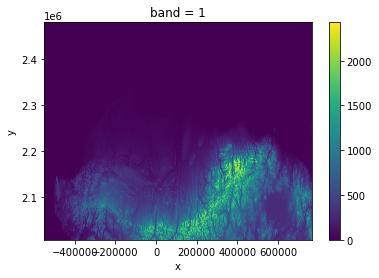

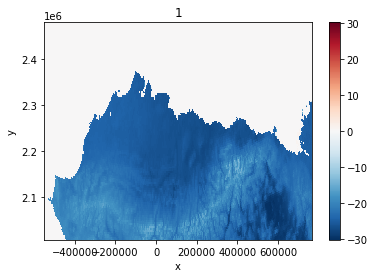

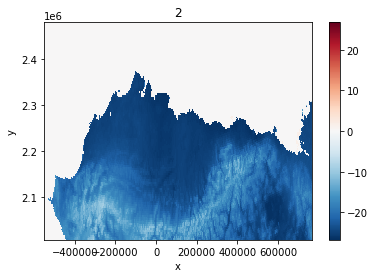

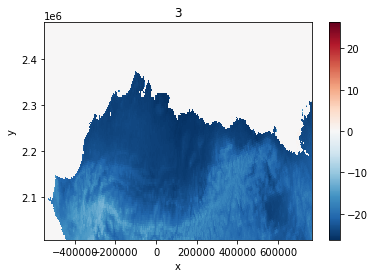

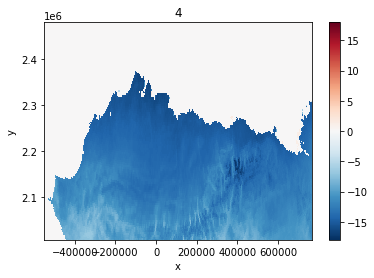

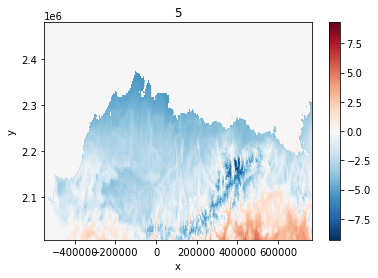

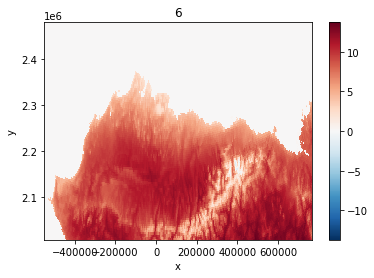

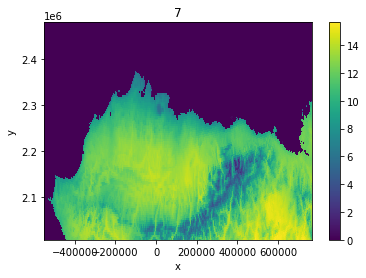

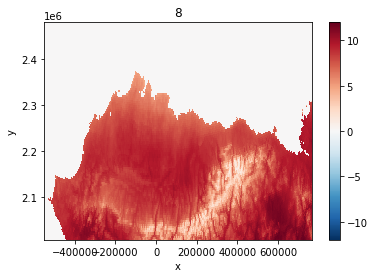

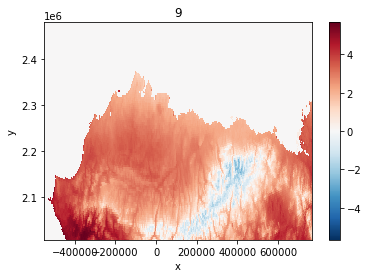

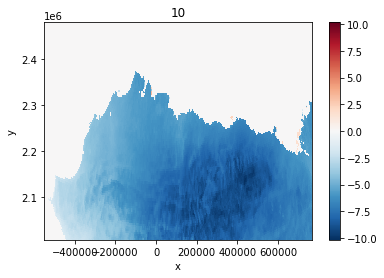

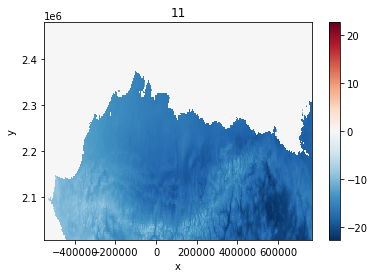

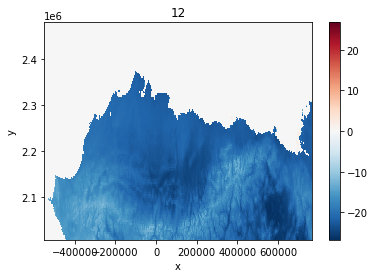

In [12]:
#plots to ensure that the lapse rates being calculated make sense 
# get dem data
INfile = dataPath+domain+'_dem.tif'
dem = xr.open_rasterio(INfile)
fig,ax = plt.subplots()
dem.plot(ax=ax)
for mo in range(12):
    month = str(mo+1)
    INfile = dataPath+'clim/'+domain+'_tmp_'+month+'.tif'
    da = xr.open_rasterio(INfile)
    fig,ax = plt.subplots()
    da.plot(ax=ax)
    plt.title(str(month))

Computing temp lapse rates
1 -4.329666658860669
2 -6.232418042107797
3 -4.625236566529755
4 -1.4344312509994273
5 -0.6626146962960184
6 0.7808353002597398
7 2.4810853324250104
8 2.5281582072095534
9 2.4080967967830356
10 2.1963068384423843
11 -0.6379056162031775
12 -3.3653222830483225


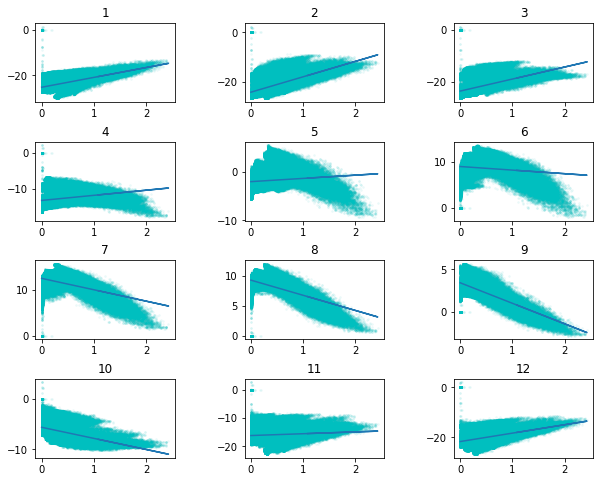

In [8]:
import matplotlib.pyplot as plt
domain = 'BEAU'
# visualize lapse rates 
fig, axs = plt.subplots(nrows=4, figsize=(10, 8), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()   
        
#months
months = np.arange(1,13).tolist()

# get dem data
INfile = dataPath+domain+'_dem.tif'
dem = xr.open_rasterio(INfile)

# compute monthly temp lapse rates 
tlapse = []
print('Computing temp lapse rates')
for mo in months:
    month = str(mo)
    INfile = dataPath+'clim/'+domain+'_tmp_'+month+'.tif'
    da = xr.open_rasterio(INfile)
    # mask out ocean in dem
    # div by 1000 to make deg / km
    demmask = dem.where(dem>0).values/1000
    # mask out ocean in climatology data
    damask = da.where(dem>0).values
    # compute polynomial coefficient 
    p = np.polyfit(demmask[~np.isnan(demmask)], damask[~np.isnan(damask)], 1)
    #use neg to make a pos number. See micromet.f for explanation
    tlapse.append(-p[0])
    print(month,-p[0])
    axs[mo-1].scatter(demmask[~np.isnan(demmask)], damask[~np.isnan(damask)],3,color= 'c',alpha = 0.05)
    axs[mo-1].set_title(str(mo))
    trendpoly = np.poly1d(p) 
    axs[mo-1].plot(demmask[~np.isnan(demmask)],trendpoly(demmask[~np.isnan(demmask)]))


Computing precip lapse rates
1 -0.3817206238836734
2 -0.22651162646766576
3 0.028307435625865327


/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


4 -0.7261398001398276
5 -0.08454791558549549
6 0.2388535233999206


/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


7 0.1983249092130967
8 -0.00023837897755368524
9 -0.453140074559199


/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/nfs/attic/dfh/miniconda/envs/ee/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


10 -0.8180519885822276
11 -0.4483547892114092
12 -0.431535647615673


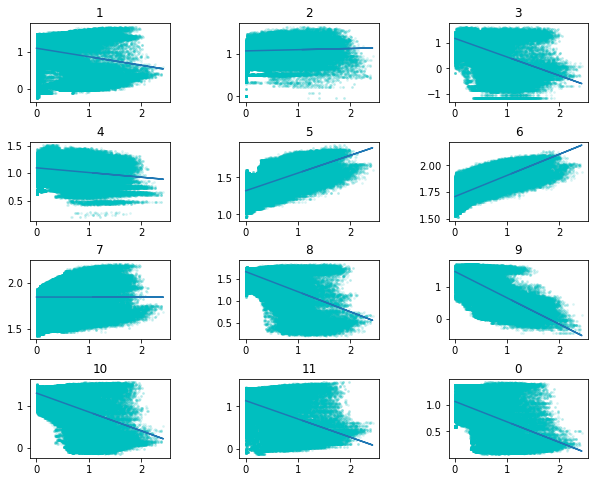

In [7]:
import matplotlib.pyplot as plt
# visualize lapse rates 
fig, axs = plt.subplots(nrows=4, figsize=(10, 8), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()   
        
#months
months = np.arange(1,13).tolist()

# get dem data
INfile = dataPath+domain+'_dem.tif'
dem = xr.open_rasterio(INfile)

# compute monthly precip lapse rates 
plapse = []
print('Computing precip lapse rates')

for mo in range(12):
    month = str(mo+1)
    INfile = dataPath+'clim/'+domain+'_ppt_'+month+'.tif'
    dap = xr.open_rasterio(INfile)
    # mask out ocean in dem
    # div by 1000 to make deg / km
    demmask = dem.where(dem>0).values/1000
    # this one is a bit tricky. Essentially, Liston uses something like
    # Thornton, 1997 (https://doi.org/10.1016/S0022-1694(96)03128-9).
    # There, we have:
    # (p1-p2)/(p1+p2)=alpha(z1-z2), where alpha is the precip
    # correction factor. This equation is basically:
    # 1/(2p) * dp/dz = alpha. This is equivalent to:
    # ln(p) = beta + 2 * alpha * z, where beta is a constant of
    # integration. So, we apply a linear fit to this to find alpha.
    pdata = np.log(dap,where=True)/2
    # mask out ocean in climatology data    
    dapmask = pdata.where(dem>0).values
    idx = np.isfinite(demmask) & np.isfinite(dapmask)
    # compute polynomial coefficient 
    p = np.polyfit(demmask[idx], dapmask[idx], 1)
    #use neg to make a pos number. See micromet.f for explanation
    plapse.append(p[0])
    print(month,p[0])
    axs[mo-1].scatter(demmask[idx], dapmask[idx],3,color= 'c',alpha = 0.1)
    axs[mo-1].set_title(str(mo))
    trendpoly = np.poly1d(p) 
    axs[mo-1].plot(demmask[idx],trendpoly(demmask[idx]))